## Recurrent Neural Networks (RNNs)
### and Long Short-Term Memory (LSTM)

In [2]:
# !pip install scipy
# !pip install sklearn

In [3]:
from tensorflow import keras
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(42)

%matplotlib inline

The neural networks we've talked about so far operate all at once. You have an input data point (or points) and the network, and the values propagate over the connections 

In this lesson we'll discuss **recurrent neural networks** (RNNs) which use time-series data as an input. The state of the network at a given point in time is based not just on the input layer at that time, but the state of the network from the previous point in time. So 

If a simple neural network looks like

<img src="img/simple-mlp.png" width=300>

A recurrent network looks like


<img src="img/rnn.png" width=300>

Where there's a connection from the hidden layer back to itself.

We can unroll this in time, showing each row as a separate time step.

<img src="img/rnn-unrolled-labeled.png" width=350>

Note that there are only three sets of weights: the vertical arrows, the horizontal arrows on the left, and the horizontal arrows on the right. To fit this model you fit those three sets of weights to the inputs $x_0$, $x_1$, $x_2$, and $x_3$ and minimize the loss between the output $\hat{x_4}$ and the label $x_4$.

Let' try this in `keras`!

Suppose we have some time-series data and we want to build a model so, given a bunch of points, we can predict the next point. For example:

In [4]:
n_pts = 500
t = np.linspace(0, 15 * 6, n_pts)
sin_t = np.sin(t)

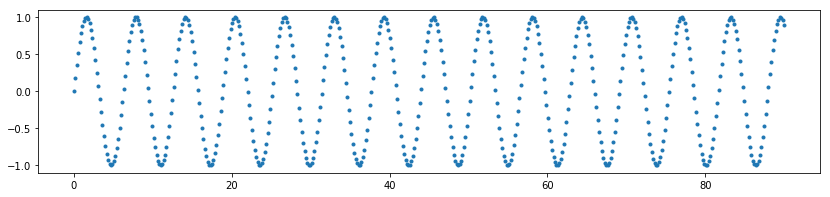

In [5]:
fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(t, sin_t, '.')

Except that's way to easy. Let's add some noise.

In [6]:
sin_t_noisy = np.sin(t) + stats.norm(0, 0.5).rvs(n_pts)

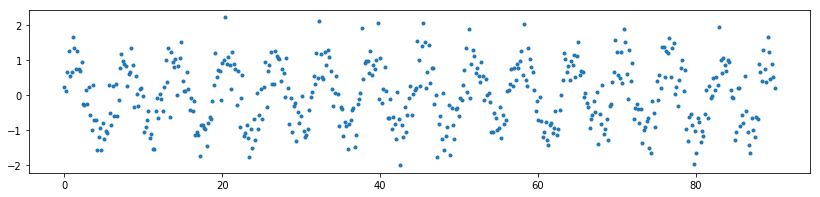

In [7]:
fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(t, sin_t_noisy, '.')

First we need to get the data into a format we can put into an RNN. Each training data point should consist of a sequence of consecutive values for our data (for input) and the next value of our data (for output).

First we'll write a function to consider every possible group of 50 values followed by one value (for the output) along our time-series data.

In [8]:
col_vec = lambda v: v[:,None] # convert 1d vector to 2d column vector

def split(ary, test_frac=0.3):
    n = int(len(ary)*test_frac)
    return ary[:-n], ary[-n:]

def windowize(data, n_prev):
    n_predictions = len(data) - n_prev
    y = data[n_prev:]
    # this might be too clever
    indices = np.arange(n_prev) + col_vec( np.arange(n_predictions) )
    x = np.expand_dims( data[indices], axis=2 )
    return x, y

In [9]:
seq_train, seq_test = split(sin_t_noisy)

Here's the training and test chunks, the first 70% and last 30% respectively

Text(0.5, 1.0, 'train/test split of noisy signal')

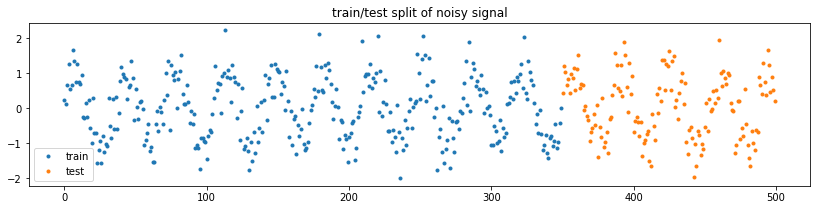

In [10]:
n_train, n_test = len(seq_train), len(seq_test)

fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(range(n_train), seq_train, ".", label="train")
ax.plot(range(n_train,n_train+n_test), seq_test, ".", label="test")
ax.legend()
ax.set_title("train/test split of noisy signal")


We can't just throw that into the model, though. As is usually the case with neural networks:
* the input needs to be a stack of consistently-sized tensors
* the output must be a label vector with the same length as the number of samples.

In this case, the "input sample" will be a 50-feature-wide chunk of signal, and the "label" will be the next item in the sequence.

In [11]:
seq_len = 50
X_train, y_train = windowize(seq_train, seq_len)
X_test, y_test = windowize(seq_test, seq_len)

In [12]:
X_train.shape # n_samples, sequence_length, n_channels

(300, 50, 1)

For example:

In [13]:
first_sample = X_train[0, :, 0] #first sample, all items, first channel (there's only one)

Text(0.5, 1.0, 'Sample sequence and target')

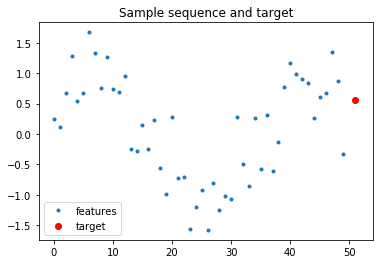

In [14]:
plt.plot( first_sample, ".", label="features" )
plt.scatter( [seq_len+1],[y_train[0]], c="red", label="target" )
plt.legend()
plt.title("Sample sequence and target")

By chopping up the train and test subsegments into consistent-sized samples, we've turned this one signal into a great many samples:

In [15]:
print( "num training samples:", len(X_train) )
print( "num test samples:", len(X_test) )

num training samples: 300
num test samples: 100


As always we have the option of simply flattening the samples and training a random forest. Let's do that just to get a benchmark:

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

clf = RandomForestRegressor(n_estimators=100)
clf.fit( X_train.reshape(-1,50), y_train )
yhat = clf.predict( X_test.reshape(-1,50) )
print( mean_squared_error( y_test, yhat ) )

0.31027314951635304


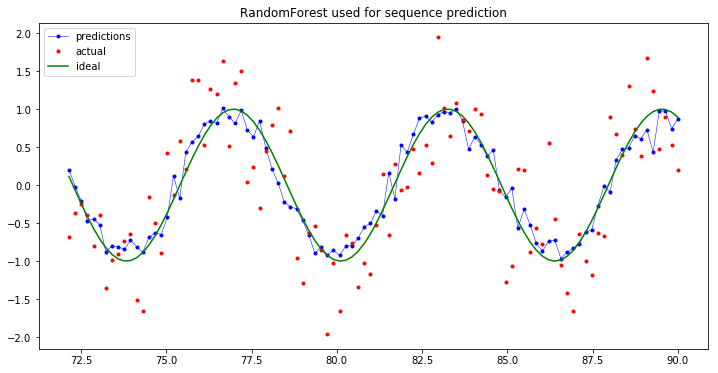

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t[-len(y_test):], yhat, 'b.-', label='predictions', lw=0.5)
ax.plot(t[-len(y_test):], y_test, 'r.', label='actual')
ax.plot(t[-len(y_test):], np.sin(t[-len(y_test):]), 'g-', label='ideal')
ax.set_title("RandomForest used for sequence prediction")
ax.legend()

Instead, we'll train a model which is specifically designed for featurizing sequences:

Now we build our model. We'll put two RNN layers.

<img src="img/rnn-2-layer-unrolled.png" width=450>

Note that for the last layer we aren't going to fit all the outputs, but just the last one, so we set `return_sequences=False`. For the previous layer that feeds into that we need the output of each step, so `return_sequences=True`.

In [18]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(32, input_shape=(seq_len, 1), return_sequences=True))
model.add(keras.layers.SimpleRNN(32, return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',
              loss='mse')

The input shape is `(seq_len, 1)` because we're training with `seq_len` prior time points and only have a single feature.

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50, 32)            1088      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X_train, y_train, batch_size=32, epochs=20, 
          validation_data=(X_test, y_test))

Train on 300 samples, validate on 100 samples
Epoch 1/20
300/300 [==============================] - 1s 4ms/sample - loss: 0.4272 - val_loss: 0.3503
Epoch 2/20
300/300 [==============================] - 0s 1ms/sample - loss: 0.3030 - val_loss: 0.3306
Epoch 3/20
300/300 [==============================] - 0s 1ms/sample - loss: 0.2783 - val_loss: 0.3321
Epoch 4/20
300/300 [==============================] - 0s 1ms/sample - loss: 0.2496 - val_loss: 0.3569
Epoch 5/20
300/300 [==============================] - 0s 1ms/sample - loss: 0.2503 - val_loss: 0.3418
Epoch 6/20
300/300 [==============================] - 0s 1ms/sample - loss: 0.2306 - val_loss: 0.3260
Epoch 7/20
300/300 [==============================] - 0s 1ms/sample - loss: 0.2280 - val_loss: 0.3841
Epoch 8/20
300/300 [==============================] - 0s 1ms/sample - loss: 0.2437 - val_loss: 0.3424
Epoch 9/20
300/300 [==============================] - 0s 1ms/sample - loss: 0.2101 - val_loss: 0.3588
Epoch 10/20
300/300 [===============

Let's see what predictions we get.

In [21]:
yhat = model.predict(X_test)

print( "RNN output mse:", mean_squared_error( y_test, yhat ) )

RNN output mse: 0.4121325942266806


So we did worse than the random forest.

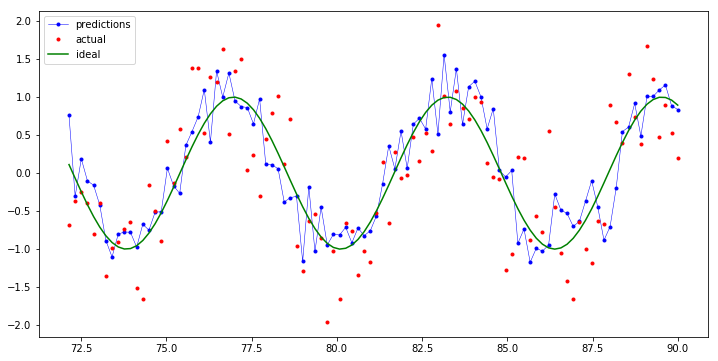

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t[-len(y_test):], yhat, 'b.-', label='predictions', lw=0.5)
ax.plot(t[-len(y_test):], y_test, 'r.', label='actual')
ax.plot(t[-len(y_test):], np.sin(t[-len(y_test):]), 'g-', label='ideal')
ax.legend()

That's not so great. Note, however, that the blue predictions do vary less than the red data points, so at least it averaged out some of the noise. 

## Diving into the RNN




The first layer of the sequential model is a "simple RNN layer". Let's get it and take it apart.

In [23]:
rnn = model.layers[0]
rnn

This will take a dataset convert into the activations of all neurons in the RNN unit for the length if the input sequence.

In [24]:
rnn_output = rnn( X_test[0:1].astype(np.float32) ).numpy()

Text(0.5, 1.0, 'neural activations over evolution of sequence')

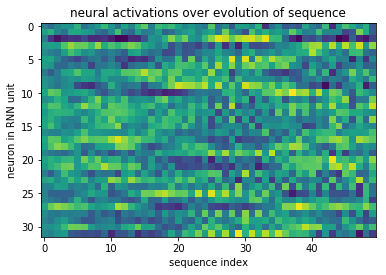

In [25]:
plt.imshow( rnn_output[0].T )
plt.xlabel("sequence index")
plt.ylabel("neuron in RNN unit")
plt.title("neural activations over evolution of sequence")

Each RNN unit has two inputs: 
* One item in a sequence $x$
  * shape: `(1, n_channels)`
* Its internal state $h$
  * shape: `(n_neurons,)`

The unit is also parameterized by three matrices 
* Input matrix $U$
  * shape: `(n_channels, n_neurons)`
* Recurrent matrix $V$
  * shape: `(n_neurons, n_neurons)`
* Bias matrix $W$.
  * shape: `(n_neurons,)`

These matrices are discovered during model training.

The LSTM has two outputs:

* $h' = \phi( Vh + Ux$ ) (same shape as h)
* $o = \phi( Wh' )$ (scalar)

(where $\phi$ is the activation function)

As implemented in various software packages, these matrices may appear transposed.

In [26]:
#feel free to confirm for yourself that the shapes make sense
U, V, W = rnn.get_weights() 

Let's actually step through this RNN unit reacting to an input

The first sequence in the training set:

In [27]:
x0 = X_test[0].astype(np.float32)

In [28]:
# the inputs are h and x
h = np.zeros(32) # the initial internal state is zeroed out
x = x0[0] # first item in the first sequence

raw_activation = V@h + x0[0]@U

h_prime = keras.activations.tanh( raw_activation ).numpy()
o = W.dot(h_prime)

Thus we converted the input sequence item into an output item, and transmuted the internal state.

In [29]:
h_prime, o

(array([-0.14641128,  0.11497023, -0.16307726,  0.07895672, -0.00962339,
         0.08822474,  0.07968119, -0.18428791, -0.02074378,  0.01152739,
         0.14833362, -0.0077624 ,  0.15137284,  0.05881202,  0.1290479 ,
         0.16493976, -0.01622536,  0.15552813,  0.08209234, -0.10653404,
         0.134327  ,  0.08596537, -0.15042601,  0.14566064, -0.09759121,
        -0.14196647, -0.0540745 ,  0.14372495, -0.01748464, -0.08416707,
        -0.00488333, -0.09155178]), 0.001677155901905693)

We could do this over and over, and it would simply return the record of the activation state of each neuron in the RNN unit:

In [30]:
activation_states = []

for i in range(seq_len):
    raw_activation = V@h + x0[i]@U
    h = keras.activations.tanh( raw_activation ).numpy()
    activation_states.append( h )

activation_states = np.stack( activation_states )

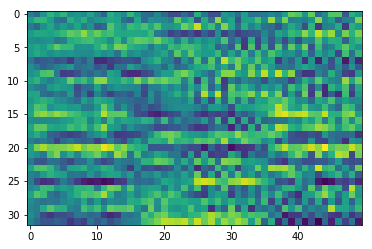

In [31]:
plt.imshow( activation_states.T )

Which we've seen before.

If we have the record of the internal state of the RNN unit over the evolution of the sequence, we can convert into the "output sequence" by dotting each state h_i against the "bias matrix" $W$:

In [32]:
output_sequence = rnn_output[0] @ W

Text(0.5, 1.0, 'Input and output sequences from first RNN layer')

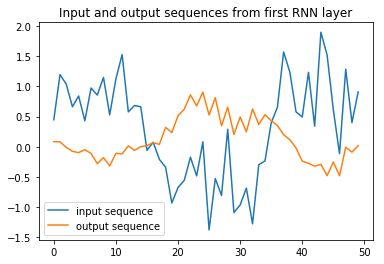

In [33]:
plt.plot( x0.flatten(), label="input sequence" )
plt.plot( output_sequence*10, label="output sequence" )
plt.legend()
plt.title("Input and output sequences from first RNN layer")

Because `return_sequences=False` was specified for the second RNN layer, the output is the neural activatons at the end of the sequence.

In [34]:
rnn2 = model.layers[1]
rnn2

In [35]:
U, V, W = rnn2.get_weights() 

Text(0.5, 1.0, 'neural activations for second RNN layer, for first sample')

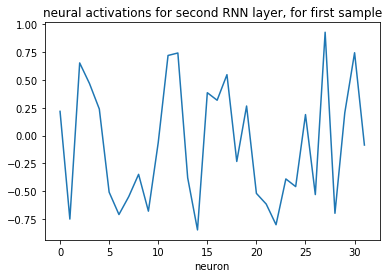

In [36]:
layer2_output = rnn2( rnn_output ).numpy()
plt.plot( layer2_output[0] )
plt.xlabel("neuron")
plt.title("neural activations for second RNN layer, for first sample")

The third layer simply performs linear regression on this sequence featurization.

In [37]:
model.layers[2]( layer2_output ).numpy()

array([[0.75799]], dtype=float32)

We did all this work, but we could have just called `model.predict` on the first sample.

In [38]:
model.predict( X_test[0:1] )

array([[0.75799]], dtype=float32)

## Long-Short-Term-Memory ("LSTM") units

One of the difficulties with traditional RNNs is what's called the "vanishing gradients problem." For neural networks (this is 50 levels deep!) the effect of the input at the beginning exponentially shrinks with the depth of the network. This makes it very hard to remember details from the disThe the signal from each successively earlier point is typically smaller (or maybe larger) than the previous is that while they can "remember" what happened recently, 

There are other architectures of RNNs that will do a better job. One is a Long Short Term Memory (LSTM) network; a good post detailing them is at [http://colah.github.io/posts/2015-08-Understanding-LSTMs/]

In [39]:
model = keras.Sequential()
model.add(keras.layers.LSTM(32, input_shape=(seq_len, 1), return_sequences=True))
model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',
              loss='mse')

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm (UnifiedLSTM)   (None, 50, 32)            4352      
_________________________________________________________________
unified_lstm_1 (UnifiedLSTM) (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(X_train, y_train, batch_size=32, epochs=10, 
          validation_data=(X_test, y_test))

Train on 300 samples, validate on 100 samples
Epoch 1/10
300/300 [==============================] - 2s 6ms/sample - loss: 0.6280 - val_loss: 0.4334
Epoch 2/10
300/300 [==============================] - 1s 2ms/sample - loss: 0.2882 - val_loss: 0.3136
Epoch 3/10
300/300 [==============================] - 1s 2ms/sample - loss: 0.2523 - val_loss: 0.3176
Epoch 4/10
300/300 [==============================] - 1s 2ms/sample - loss: 0.2551 - val_loss: 0.2977
Epoch 5/10
300/300 [==============================] - 1s 2ms/sample - loss: 0.2452 - val_loss: 0.2976
Epoch 6/10
300/300 [==============================] - 1s 2ms/sample - loss: 0.2578 - val_loss: 0.3080
Epoch 7/10
300/300 [==============================] - 1s 2ms/sample - loss: 0.2428 - val_loss: 0.3057
Epoch 8/10
300/300 [==============================] - 1s 2ms/sample - loss: 0.2516 - val_loss: 0.3032
Epoch 9/10
300/300 [==============================] - 1s 2ms/sample - loss: 0.2458 - val_loss: 0.2978
Epoch 10/10
300/300 [===============

In [42]:
yhat = model.predict(X_test)

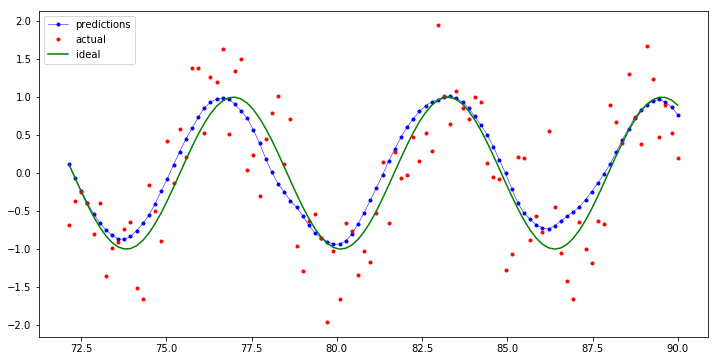

In [43]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t[-len(y_test):], yhat, 'b.-', label='predictions', lw=0.5)
ax.plot(t[-len(y_test):], y_test, 'r.', label='actual')
ax.plot(t[-len(y_test):], np.sin(t[-len(y_test):]), 'g-', label='ideal')
ax.legend()

This does slightly better than the RandomForest sequence predictor. Also, it makes smoother predictions.

I won't go diving into the implementation of LSTM units - it's a lot more complicated than fully-connected RNN units - but each LSTM cell still has a number of neurons (specified in the Keras sequence definition) and the output of the first layer is the trace of the activations of all neurons.

Text(0.5, 0, 'neuron')

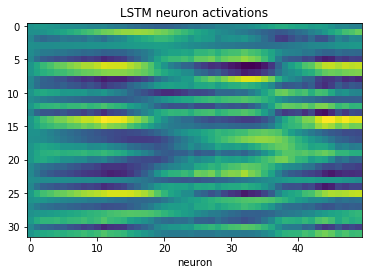

In [44]:
plt.imshow( model.layers[0]( X_test[0:1].astype(np.float32) ).numpy()[0].T )
plt.title("LSTM neuron activations")
plt.xlabel("neuron")

# Classification

RNNs can also be used for classification. Rather than predicting the next step after a sequence as the output, we predict a class (or rather, a probability). Let's try two sequences, sine waves of slightly difference frequencies.

In [59]:
n_pts = 500
t = np.linspace(0, 15 * 6, n_pts)
sin_11t_noisy = np.sin(1.1*t) + stats.norm(0, 0.5).rvs(n_pts)
sin_t_noisy = np.sin(t) + stats.norm(0, 0.5).rvs(n_pts)

We don't care about the next value any more.

In [60]:
(X_train1, _), (X_test1, _) = [windowize(x, 50) for x in split(sin_t_noisy)]
(X_train2, _), (X_test2, _) = [windowize(x, 50) for x in split(sin_11t_noisy)]

Instead, the `y`s are the labels of the class.

In [61]:
X_train = np.concatenate([X_train1, X_train2])
X_test = np.concatenate([X_test1, X_test2])
y_train = np.concatenate([np.zeros(X_train1.shape[0]), np.ones(X_train2.shape[0])])
y_test = np.concatenate([np.zeros(X_test1.shape[0]), np.ones(X_test2.shape[0])])

We'll use a sigmoid activation at the end.

In [62]:
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(32, input_shape=(seq_len, 1), return_sequences=True))
model.add(keras.layers.LSTM(32, input_shape=(seq_len, 1), return_sequences=True))
model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',metrics=["accuracy"])

In [63]:
y_train.shape, y_test.shape

((600,), (200,))

In [64]:
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

Train on 600 samples, validate on 200 samples
Epoch 1/10
600/600 [==============================] - 3s 5ms/sample - loss: 0.6947 - accuracy: 0.5200 - val_loss: 0.6879 - val_accuracy: 0.5750
Epoch 2/10
600/600 [==============================] - 1s 2ms/sample - loss: 0.6601 - accuracy: 0.6233 - val_loss: 0.6329 - val_accuracy: 0.7000
Epoch 3/10
600/600 [==============================] - 1s 2ms/sample - loss: 0.5466 - accuracy: 0.7367 - val_loss: 0.5545 - val_accuracy: 0.7550
Epoch 4/10
600/600 [==============================] - 1s 2ms/sample - loss: 0.4407 - accuracy: 0.8267 - val_loss: 0.4857 - val_accuracy: 0.6850
Epoch 5/10
600/600 [==============================] - 1s 2ms/sample - loss: 0.4371 - accuracy: 0.7933 - val_loss: 0.6503 - val_accuracy: 0.7200
Epoch 6/10
600/600 [==============================] - 1s 2ms/sample - loss: 0.3798 - accuracy: 0.8233 - val_loss: 0.4265 - val_accuracy: 0.8350
Epoch 7/10
600/600 [==============================] - 1s 2ms/sample - loss: 0.2968 - accur

In [65]:
yhat = model.predict(X_test)[:,0]

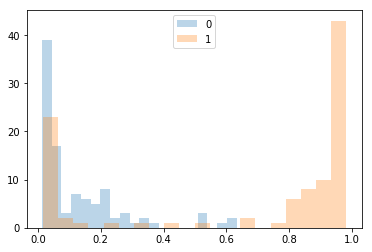

In [66]:
fix, ax = plt.subplots()
ax.hist(yhat[y_test == 0], alpha=0.3, bins=20, label="0")
ax.hist(yhat[y_test == 1], alpha=0.3, bins=20, label="1")
ax.legend()

# Regression

Maybe we could use an RNN to figure out the frequency of a signal. Here we'll just create a lot of sequences (with noise), each with a different frequency and starting point. 

In [67]:
n_pts = 50
n_sequences = 1000
length = 10  # length of each sequence
xpts = np.linspace(0, length, n_pts)
offsets = stats.uniform(0, 2*np.pi).rvs(n_sequences)[:, None]
freqs = stats.uniform(1,4).rvs(n_sequences)[:, None]
signals = np.sin(xpts*freqs + offsets) + stats.norm(0, 0.3).rvs((n_sequences, n_pts))

Let's look at some of the sequences.

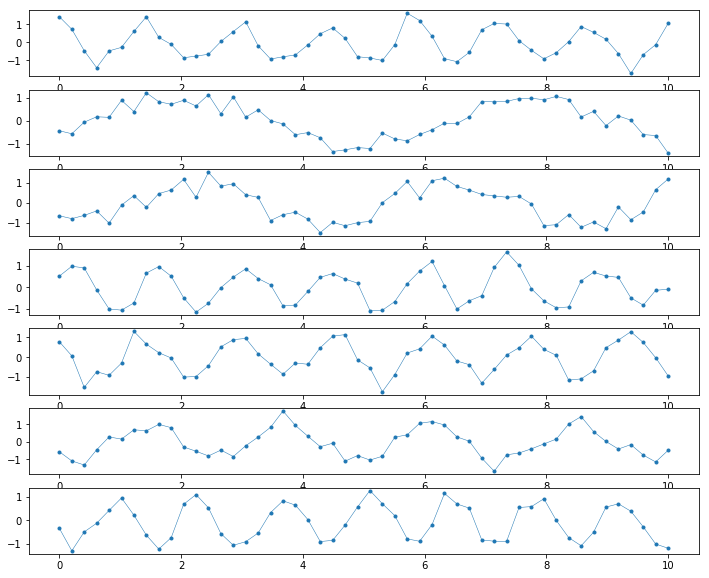

In [68]:
fig, axs = plt.subplots(7, 1, figsize=(12,10))
for i, ax in zip(range(7), axs):
    ax.plot(xpts, signals[i], '.-', lw=0.5)


In [69]:
model = keras.Sequential()
#model.add(keras.layers.LSTM(32, input_shape=(n_pts, 1), return_sequences=True))
#model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.LSTM(32, input_shape=(n_pts, 1), return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',
              loss='mse')

In [70]:
X_train, X_test, y_train, y_test = train_test_split(signals[:, :, None], freqs[:, 0])

In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((750, 50, 1), (250, 50, 1), (750,), (250,))

In [72]:
model.fit(X_train, y_train,  batch_size=32, epochs=20, 
          validation_data=(X_test, y_test))

Train on 750 samples, validate on 250 samples
Epoch 1/20
750/750 [==============================] - 1s 2ms/sample - loss: 5.5035 - val_loss: 1.4016
Epoch 2/20
750/750 [==============================] - 1s 844us/sample - loss: 1.3057 - val_loss: 1.3582
Epoch 3/20
750/750 [==============================] - 1s 854us/sample - loss: 1.2688 - val_loss: 1.4123
Epoch 4/20
750/750 [==============================] - 1s 878us/sample - loss: 1.0472 - val_loss: 0.9406
Epoch 5/20
750/750 [==============================] - 1s 891us/sample - loss: 0.5794 - val_loss: 0.6579
Epoch 6/20
750/750 [==============================] - 1s 928us/sample - loss: 0.4519 - val_loss: 0.2607
Epoch 7/20
750/750 [==============================] - 1s 932us/sample - loss: 0.4253 - val_loss: 0.2626
Epoch 8/20
750/750 [==============================] - 1s 960us/sample - loss: 0.3842 - val_loss: 0.2945
Epoch 9/20
750/750 [==============================] - 1s 1ms/sample - loss: 0.3922 - val_loss: 0.2407
Epoch 10/20
750/750 [=

In [73]:
yhat = model.predict(X_test)

How did we do?

Text(0.5, 1.0, 'test value vs prediction')

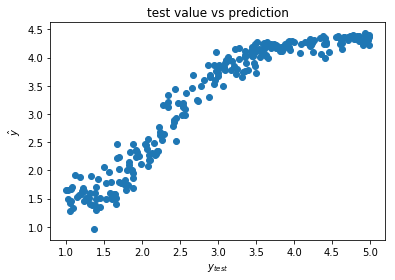

In [74]:
fig, ax = plt.subplots()
ax.scatter(y_test, yhat)
ax.set_xlabel("$y_{test}$")
ax.set_ylabel("$\hat{y}$")
ax.set_title("test value vs prediction")

## Super extra credit

If for some reason we still have a lot of time, which is impossible, check out [generating text with an RNN](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/text/text_generation.ipynb#scrollTo=AM2Uma_-yVIq).